# Signal to Noise Ratio (SNR)

This Notebook is Copyright ©Patrik Lechner 2021 under Creative Commons, Attribution-ShareAlike 4.0 International. [![License: CC BY-SA 4.0](https://licensebuttons.net/l/by-sa/4.0/80x15.png)](https://creativecommons.org/licenses/by-sa/4.0/)

This notebook documents how to calculate the Signal to Noise Ratio (SNR) for audio applications in python. This measure is used in many engineering disciplines. In audio applications, the desired signals mostly contain AC components that should not be confused with noise, making simple approaches focusing on DC signals not very useful. 4 Methods are shown here:
- Method 1 assumes we can measure/record a noise only signal, emmitted by the system in question without an input signal.
- Method 2 assumes we can measure an input signal and an output signal of a system. It is assumed that their difference is noise, which is not always the case, especially when we want to measure the SNR of a system that actually does something.
- Method 3 uses the FFT to analyse for a fundamental frequency. It assumes that the input is a sinusoidal signal, the system adds noise and can contain weak non-linearities.
- Methos 4 is here mostly for reference and is mostly suited for DC signals (not audio signals)


## Basic Definition
A discrete time signal, $x_s(n)$ exists. Through some process, noise $x_n(n)$ and harmonics of $x$ are added, resulting in a new signal, $y(n)$ that therefore contains noise and distortion.

The main idea is to make a *ratio* between signal power to noise power. 


$$ SNR = \frac{P_{signal}}{P_{noise}} $$

So we need to measure the *power* $P(x)$ of a signal $x(n)$,  via:

$$P(x)=1/N \cdot \displaystyle\sum_{n=0}^{N-1}x(n)^2$$

Which is simply taking the square of the signal and then the average.


We can then calculate the $SNR$ via the power ratios:

$$ SNR = \frac{P_{signal}}{P_{noise}}$$

Typically we want to have the values in dB. Since we have power signals alread we need to use 

$$P_{db} = 10 \cdot log_{10} (P) $$

So
$$ SNR_{db} = 10 \log_{10} \frac{P_{signal}}{P_{noise}}$$

This is it. Actually, we can also convert the power levels first to dB and then subtract (subtracting to logarithmic values is the same as dividing to linear ones):


$$ 
10 \log_{10} \left ( \frac{P_\mathrm{signal}}{P_\mathrm{noise}} \right ) = 10 \log_{10} \left ( P_\mathrm{signal} \right ) - 10 \log_{10} \left ( P_\mathrm{noise} \right )
$$


## Measuring

### Method 1
Sometimes, the question arises how to get the noise and the Signal separately.
One method is to measure the constant noise power a device *produces without an input*, let's call that $P_n$ and measure the power of the output of a device *with* an input, lets call that $P_s$. By subtraction of the powers, we can estimate the power of the signal alone and therefore the ratio between signal and noise power (assuming noise power stays constant).     

$$ SNR_{db}=10 \cdot \log_{10} \frac {P_s - P_n}{P_n}$$

- $P(s)$ is a function that computes the power of a signal.
- $P_s$ in this case is the power of the signal + the noise, typically the output of the system we want to measure **with** an input signal.
- $P_n$ in this case is the power of just the noise, typically the output of the system we want to measure **without** an input signal.

### Method 2
Another method is to try to make the system as clean as possible (eg bypass or similar *at unity gain!*), measure input signal power $P_i$ and output signal power $P_o$ and just assume that the difference between them is the level of noise being added:
$$ P_n = P_o - P_i $$
The rest of the comutation stays the same as Method 1.


### Method 3: Spectral
The spectral method is modeled after the matlab function `snr`. The periodogram is calculated, the fundamental frequency is detected via the maximum, the harmonics are detected by looking for local maxima where harmonic peaks should be located (including aliased ones). These peaks are removed and the powers of the remaining signal (assumed to be the noise) is compared to the fundamental frequencie's power.

### Method 4: Standard deviation 
This method can be found all over the internet but is not so interesting for Audio applications (AC signals). It is for instance used in an [old release of scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.signaltonoise.html).



## refs:
- https://en.wikipedia.org/wiki/Signal-to-noise_ratio
- https://de.mathworks.com/help/signal/ref/snr.html
- https://dsp.stackexchange.com/questions/17871/how-to-calculate-signal-to-noise-ratio
- https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.signaltonoise.html
- https://de.mathworks.com/help/signal/ref/bandpower.html
- http://classes.engr.oregonstate.edu/eecs/spring2017/ece627/Lecture%20Notes/FFT%20for%20delta-sigma%20spectrum%20estimation.pdf
- https://de.mathworks.com/help/signal/ref/snr.html
- https://training.ti.com/sites/default/files/docs/TIPL%204703%20-%20Understanding%20Signal%20to%20Noise%20Ratio%20and%20Noise%20Spectral%20Density%20in%20High%20Speed%20Datat%20Converters_3.pdf
- https://stackoverflow.com/questions/63177236/how-to-calculate-signal-to-noise-ratio-using-python
- https://github.com/scipy/scipy/issues/9097
- https://www.codespeedy.com/calculate-signal-to-noise-ratio-in-python/
- https://biosignalsplux.com/learn/notebooks/Categories/Pre-Process/snr_slow_signals_rev.php

# Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# !pip install seaborn

In [3]:
import seaborn as sn
from scipy.stats import norm
import scipy.signal as sig
import copy

In [4]:
sn.set_theme()

In [5]:
sr = 48000
T = 0.1 #seconds
N = int(T*sr)
n = arange(N)
t = n/sr

silence = zeros(N)

SNR by definition, not computation: 16.989700043360187 dB


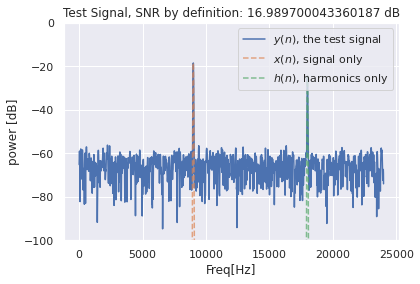

In [6]:
np.random.seed(1) #reproducability

# matlab like randn function, for comparison reasons with matlab code. Only needed to create test signal.
matlabRandn = lambda n:norm.ppf(np.random.rand(1,n)).flatten()

A = 1.0
a = 0.5
s = 0.1
powFund = A**2/2
powHarm = a**2/2
varnoise = s**2
f0 = 9000#*(sr/2)
h1 = f0*2.
noiseOnly = s*matlabRandn(len(t))
signalOnly = A * cos(pi*2*f0*t)
harmonicsOnly = a*sin(pi*2*t*h1)
y = signalOnly + harmonicsOnly + noiseOnly

faxis,psX = sig.periodogram(signalOnly,fs=sr, window=('kaiser',38))
faxis,psH = sig.periodogram(harmonicsOnly,fs=sr, window=('kaiser',38))

defSNR = 10*log10(powFund/varnoise)
print('SNR by definition, not computation: {} dB'.format(defSNR))

faxis,ps = sig.periodogram(y,fs=sr, window=('kaiser',38))
fundBin = argmax(ps) 

_=plot(faxis,10*log10(ps), label='$y(n)$, the test signal')
_=plot(faxis,10*log10(psX),'--', label='$x(n)$, signal only', alpha=0.7)
_=plot(faxis,10*log10(psH),'--', label='$h(n)$, harmonics only', alpha=0.7)
title('Test Signal, SNR by definition: {} dB'.format(defSNR))
ylim([-100,0])
xlabel('Freq[Hz]')
ylabel('power [dB]')
legend()
grid(True)

# Method 1 & 2

In [7]:
exampleInput = signalOnly #record a systems input here
exampleOutput = y # record a systems output (with an input signal) here
noiseOnly = noiseOnly # recording the systems output without an input signal.

In [8]:
def signalPower(x):
    return average(x**2)

In [9]:
def SNR(signal, noise):
    powS = signalPower(signal)
    powN = signalPower(noise)
    return 10*log10((powS-powN)/powN)

In [10]:
def SNRsystem(inputSig, outputSig):
    noise = outputSig-inputSig
    
    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*log10((powS-powN)/powN)

In [11]:
method1 = SNR(exampleOutput,noiseOnly)
print("Result Method 1: {} dB".format(method1))

Result Method 1: 17.971278119623197 dB


In [12]:
method2 = SNRsystem(exampleInput,exampleOutput)
print("Result Method 2: {} dB".format(method2))

Result Method 2: 5.7231662754316766 dB


# Method 3: Spectral

- https://de.mathworks.com/help/signal/ref/bandpower.html
- http://classes.engr.oregonstate.edu/eecs/spring2017/ece627/Lecture%20Notes/FFT%20for%20delta-sigma%20spectrum%20estimation.pdf
- https://de.mathworks.com/help/signal/ref/snr.html
- https://training.ti.com/sites/default/files/docs/TIPL%204703%20-%20Understanding%20Signal%20to%20Noise%20Ratio%20and%20Noise%20Spectral%20Density%20in%20High%20Speed%20Datat%20Converters_3.pdf

In [13]:
def bandpower(ps, mode='psd'):
    """
    estimate bandpower, see https://de.mathworks.com/help/signal/ref/bandpower.html
    """
    if mode=='time':
        x = ps
        l2norm = linalg.norm(x)**2./len(x)
        return l2norm
    elif mode == 'psd':
        return sum(ps)        

In [14]:
def getIndizesAroundPeak(arr, peakIndex,searchWidth=1000):
    peakBins = []
    magMax = arr[peakIndex]
    curVal = magMax
    for i in range(searchWidth):
        newBin = peakIndex+i
        newVal = arr[newBin]
        if newVal>curVal:
            break
        else:
            peakBins.append(int(newBin))
            curVal=newVal
    curVal = magMax
    for i in range(searchWidth):
        newBin = peakIndex-i
        newVal = arr[newBin]
        if newVal>curVal:
            break
        else:
            peakBins.append(int(newBin))
            curVal=newVal
    return array(list(set(peakBins)))



In [15]:
def freqToBin(fAxis, Freq):
    return argmin(abs(fAxis-Freq))

def getPeakInArea(psd, faxis, estimation, searchWidthHz = 10):
    """
    returns bin and frequency of the maximum in an area
    """
    binLow = freqToBin(faxis, estimation-searchWidthHz)
    binHi = freqToBin(faxis, estimation+searchWidthHz)
    peakbin = binLow+argmax(psd[binLow:binHi])
    return peakbin, faxis[peakbin]

def getHarmonics(fund,sr,nHarmonics=6,aliased=False):
    harmonicMultipliers = arange(2,nHarmonics+2)
    harmonicFs = fundFrequency*harmonicMultipliers
    if not aliased:
        harmonicFs[harmonicFs>sr/2] = -1
        harmonicFs = np.delete(harmonicFs,harmonicFs==-1)
    else:
        nyqZone = floor(harmonicFs/(sr/2))
        oddEvenNyq = nyqZone%2  
        harmonicFs = mod(harmonicFs,sr/2)
        harmonicFs[oddEvenNyq==1] = (sr/2)-harmonicFs[oddEvenNyq==1]
    return harmonicFs   

In [16]:
faxis,ps = sig.periodogram(y,fs=sr, window=('kaiser',38)) #get periodogram, parametrized like in matlab
fundBin = argmax(ps) #estimate fundamental at maximum amplitude, get the bin number
fundIndizes = getIndizesAroundPeak(ps,fundBin) #get bin numbers around fundamental peak
fundFrequency = faxis[fundBin] #frequency of fundamental


In [17]:
nHarmonics = 6
harmonicFs = getHarmonics(fundFrequency,sr,nHarmonics=nHarmonics,aliased=True) #get harmonic frequencies
print('harmonic frequencies estimated: {}'.format(harmonicFs))

harmonic frequencies estimated: [18000. 21000. 12000.  3000.  6000. 15000.]


## Search maxima near estimated harmonic frequencies

In [18]:
harmonicBorders = zeros([2,nHarmonics],dtype=int16).T
fullHarmonicBins = np.array([], dtype=int16)
fullHarmonicBinList = []
harmPeakFreqs=[]
harmPeaks=[]
for i,harmonic in enumerate(harmonicFs):
    searcharea = 0.1*fundFrequency
    estimation = harmonic
    
    binNum, freq = getPeakInArea(ps,faxis,estimation,searcharea)
    harmPeakFreqs.append(freq)
    harmPeaks.append(ps[binNum])
    allBins = getIndizesAroundPeak(ps, binNum,searchWidth=1000)
    fullHarmonicBins=np.append(fullHarmonicBins,allBins)
    fullHarmonicBinList.append(allBins)
    harmonicBorders[i,:] = [allBins[0], allBins[-1]]
    print(freq)

18000.0
20720.0
11230.0
2230.0
5880.0
14690.0


In [19]:
fundIndizes.sort()
pFund = bandpower(ps[fundIndizes[0]:fundIndizes[-1]]) #get power of fundamental 
fundRemoved = np.delete(ps,fundIndizes) #remove the fundamental (start constructing the noise-only signal)
fAxisFundRemoved = np.delete(faxis,fundIndizes)

In [20]:
def plotSNR(ps, faxis, fundIndizes, fullHarmonicBinList, harmPeaks, harmPeakFreqs, ):
    fig, ax = plt.subplots()
    arrowprops = dict(
        arrowstyle="->",
        connectionstyle="angle,angleA=0,angleB=90,rad=10")
    bbox = dict(boxstyle="round", fc="0.8")
    offset = 10


    plot(faxis,10*log10(ps), c='r', label='noise')
    plot(faxis[fundIndizes], 10*log10(ps[fundIndizes]), c='b', label='$f_0$')
    for i,harm in enumerate(fullHarmonicBinList):
        plot(faxis[harm], 10*log10(ps[harm]),'k')

        ax.annotate("f{}".format(i+1),
        (harmPeakFreqs[i], 10*log10(harmPeaks[i])),
        xytext=(0, 30), textcoords='offset points',
        bbox=bbox, arrowprops=arrowprops)

    legend()
    return

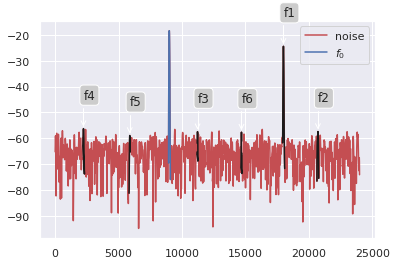

In [21]:
plotSNR(ps,faxis, fundIndizes,fullHarmonicBinList,harmPeaks,harmPeakFreqs)

In [22]:
noisePrepared = copy.copy(ps)
noisePrepared[fundIndizes] = 0
noisePrepared[fullHarmonicBins] = 0
noiseMean = median(noisePrepared[noisePrepared!=0])
noisePrepared[fundIndizes] = noiseMean 
noisePrepared[fullHarmonicBins] = noiseMean

In [23]:
noisePower = bandpower(noisePrepared)

In [24]:
r = 10*log10(pFund/noisePower)

In [25]:
print('SNR by definition, not computation: {} dB'.format(defSNR))
print('measured SNR: {} dB'.format(r))
print('Noise Power: {} dB'.format(10*log10(noisePower)))

SNR by definition, not computation: 16.989700043360187 dB
measured SNR: 17.492608014457396 dB
Noise Power: -30.5125961288058 dB


In [26]:
# onlyNoise = fundRemoved

# Method 4: Std Deviation 
- https://stackoverflow.com/questions/63177236/how-to-calculate-signal-to-noise-ratio-using-python
- https://github.com/scipy/scipy/issues/9097
- https://www.codespeedy.com/calculate-signal-to-noise-ratio-in-python/
- https://biosignalsplux.com/learn/notebooks/Categories/Pre-Process/snr_slow_signals_rev.php

Returns the signal-to-noise ratio of a, here defined as the mean divided by the standard deviation.
A similar approach uses a low-pass filter to remove the noise and estimate signal level (which is mathematically eqivalent to using the mean, which is essentially calculating the level at 0 Hz). 
This of course poses a problem in case the signal's fundamental frequency is high or the noise has a lot of power in low frequency ranges.

Trying to apply this function with the above testsignal gives quite an error:

In [27]:
import numpy as np

def signaltonoiseScipy(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNRscipy = 20*log10(abs(signaltonoiseScipy(y)))

print("SNR by scipy: {} dB".format(SNRscipy))

SNR by scipy: -67.1231656329781 dB


## Low frequency Signal
Because of this filtering, tis method is only useful for low frequncy signals. Therefore, the fundamental frequency is set to 1 Hz here and the harmonics are reduced, to show that it leads to comparably results for these signals. 

SNR by definition, not computation: 16.989700043360187 dB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


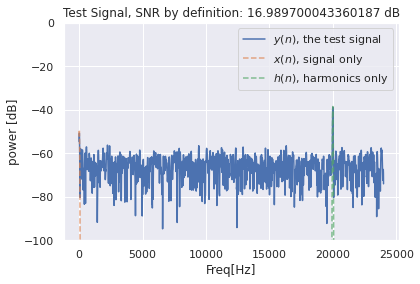

In [28]:
np.random.seed(1) #reproducability

# matlab like randn function, for comparison reasons with matlab code. Only needed to create test signal.
matlabRandn = lambda n:norm.ppf(np.random.rand(1,n)).flatten()

A = 1.0
a = 0.1
s = 0.1
powFund = A**2/2
powHarm = a**2/2
varnoise = s**2

f0 = 1#*(sr/2)
h1 = 20000
noiseOnly = s*matlabRandn(len(t))
signalOnly = A * cos(pi*2*f0*t)
harmonicsOnly = a*sin(pi*2*t*h1)
y = signalOnly + harmonicsOnly + noiseOnly

faxis,psX = sig.periodogram(signalOnly,fs=sr, window=('kaiser',38))
faxis,psH = sig.periodogram(harmonicsOnly,fs=sr, window=('kaiser',38))

defSNR = 10*log10(powFund/varnoise)
print('SNR by definition, not computation: {} dB'.format(defSNR))

faxis,ps = sig.periodogram(y,fs=sr, window=('kaiser',38))
fundBin = argmax(ps) 

_=plot(faxis,10*log10(ps), label='$y(n)$, the test signal')
_=plot(faxis,10*log10(psX),'--', label='$x(n)$, signal only', alpha=0.7)
_=plot(faxis,10*log10(psH),'--', label='$h(n)$, harmonics only', alpha=0.7)
title('Test Signal, SNR by definition: {} dB'.format(defSNR))
ylim([-100,0])
xlabel('Freq[Hz]')
ylabel('power [dB]')
legend()
grid(True)

In [29]:
SNRscipy = 20*log10(abs(signaltonoiseScipy(y)))

print("SNR by scipy: {} dB".format(SNRscipy))

SNR by scipy: 16.74421736726376 dB
